<a href="https://colab.research.google.com/github/Omid-Hassasfar/CHPC2024-QuantumComputing/blob/main/CHPC_2024_QC_SpinSystemSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authors of main paper : Jarrett L. Lancaster and D. Brysen Allen.

Adaptation for the CHPC 2024 Workshop by Abbas (Omid) Hassasfar.

In [9]:
!pip install qiskit[visualization] --quiet  # Install Qiskit with visualization support
!pip install qiskit-ibm-runtime --quiet     # Install Qiskit IBM Runtime for accessing IBM Quantum services
!pip install qiskit-aer --quiet             # Install Qiskit Aer for high-performance quantum simulations

## Importing Packages!

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
import scipy as sp

import qiskit
import qiskit_ibm_runtime
import qiskit_aer
import matplotlib

print(f'Qiskit: {qiskit.__version__}')
print(f'Qiskit Aer: {qiskit_aer.__version__}')
print(f'Qiskit IBM Runtime: {qiskit_ibm_runtime.__version__}')
print()
print("Numpy version:", np.__version__)
print("Scipy version:", sp.__version__)
print("Sympy version:", sp.__version__)
print("Matplotlib version:", matplotlib.__version__)
print()
!python --version

Qiskit: 1.3.0
Qiskit Aer: 0.15.1
Qiskit IBM Runtime: 0.33.2

Numpy version: 1.26.4
Scipy version: 1.13.1
Sympy version: 1.13.1
Matplotlib version: 3.8.0

Python 3.10.12


In [11]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile

from qiskit.circuit import Parameter

from qiskit.primitives import StatevectorSampler, StatevectorEstimator, Sampler, Estimator

from qiskit.result import marginal_distribution

from qiskit.providers.basic_provider import BasicProvider

from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector, plot_state_qsphere, plot_state_city

from qiskit.quantum_info import Statevector, Operator, SparsePauliOp, concurrence

from qiskit.circuit.library import PauliEvolutionGate, UGate, QFT

from qiskit_aer import AerSimulator, StatevectorSimulator, UnitarySimulator

from math import pi, cos, sin

from random import randrange

https://github.com/Omid-Hassasfar/qiskit-tutorial-Archive/blob/master/tutorials/circuits/3_summary_of_quantum_operations.ipynb

https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.UGate

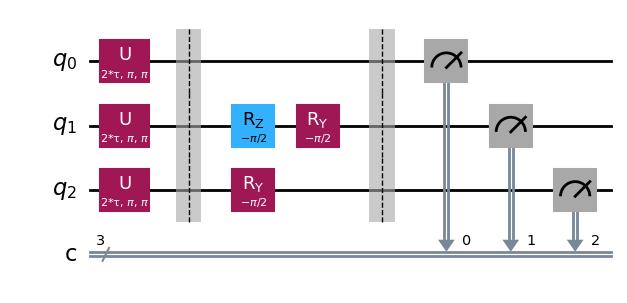

In [12]:
tau = Parameter('τ')
Nt = 75
qr = QuantumRegister(3,'q')
cr = ClassicalRegister(3,'c')

timecirc = QuantumCircuit(qr,cr)

#no initial unitary transformation since |ψ(0)> = |0>

timecirc.u(2*tau,np.pi,np.pi,qr) #apply exp(-iHt/ħ)
timecirc.barrier(qr)
timecirc.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc.rz(-np.pi/2,1)
timecirc.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc.barrier(qr)
#no rotation needed to measure <Sz>

timecirc.measure(qr,cr)
timecirc.draw('mpl')

In [13]:
tau_range = np.linspace(0, 2*np.pi, Nt)

sampler = StatevectorSampler()

nshots = 8192

pub = (timecirc, tau_range)

job = sampler.run([pub], shots=nshots)
result = job.result()[0]

In [14]:
Sx = np.zeros(Nt)
Sy = np.zeros(Nt)
Sz = np.zeros(Nt)

for n in range(0,Nt):
    simcounts = result.data.c.get_counts(n)
    states = list(simcounts.keys())
    for j in range(0,len(states)):
        state = states[j]
        if (state[0]=='0'):
            Sx[n] = Sx[n] + 0.5*simcounts[state]/nshots
        else:
            Sx[n] = Sx[n] - 0.5*simcounts[state]/nshots

        if (state[1]=='0'):
            Sy[n] = Sy[n] + 0.5*simcounts[state]/nshots
        else:
            Sy[n] = Sy[n] - 0.5*simcounts[state]/nshots

        if (state[2]=='0'):
            Sz[n] = Sz[n] + 0.5*simcounts[state]/nshots
        else:
            Sz[n] = Sz[n] - 0.5*simcounts[state]/nshots

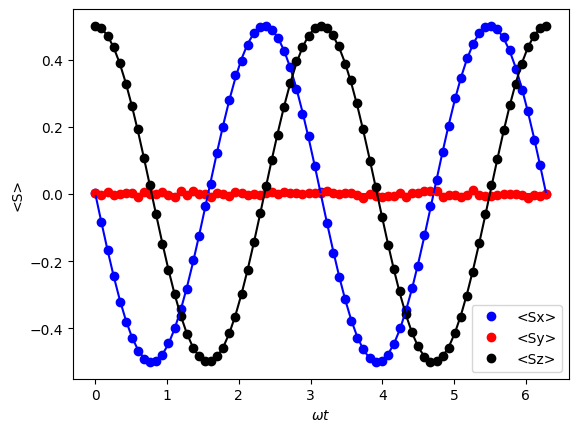

In [15]:
plt.plot(tau_range,Sx,'bo',label='<Sx>')
plt.plot(tau_range,Sy,'ro',label='<Sy>')
plt.plot(tau_range,Sz,'ko',label='<Sz>')
plt.plot(tau_range,-0.5*np.sin(2*tau_range),'b-')
plt.plot(tau_range,0*tau_range,'r-')
plt.plot(tau_range,0.5*np.cos(2*tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

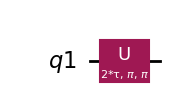

In [16]:
tau = Parameter('τ')

Nt = 75
qr = QuantumRegister(1)

timecirc2 = QuantumCircuit(qr)

#no initial unitary transformation since |ψ(0)> = |0>

timecirc2.u(2*tau,np.pi,np.pi,qr) #apply exp(-iHt/ħ)

timecirc2.draw('mpl')

In [17]:
Sx = SparsePauliOp.from_list([("X", 0.5)])
Sy = SparsePauliOp.from_list([("Y", 0.5)])
Sz = SparsePauliOp.from_list([("Z", 0.5)])

In [18]:
estimator = StatevectorEstimator()

pub = (
    timecirc2,  # circuit
    [[Sx], [Sy], [Sz]],  # Observables
    tau_range,
)

job_result = estimator.run(pubs=[pub]).result()

In [19]:
sx_est = job_result[0].data.evs[0]
sy_est = job_result[0].data.evs[1]
sz_est = job_result[0].data.evs[2]

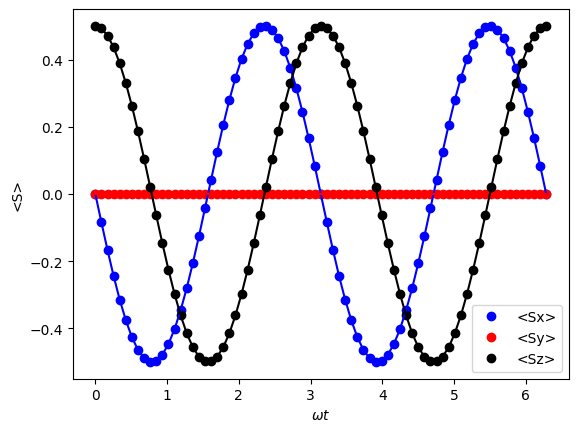

In [20]:
plt.plot(tau_range,sx_est,'bo',label='<Sx>')
plt.plot(tau_range,sy_est,'ro',label='<Sy>')
plt.plot(tau_range,sz_est,'ko',label='<Sz>')
plt.plot(tau_range,-0.5*np.sin(2*tau_range),'b-')
plt.plot(tau_range,0*tau_range,'r-')
plt.plot(tau_range,0.5*np.cos(2*tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

---
---

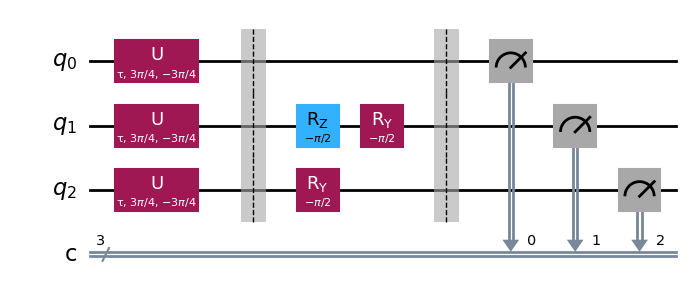

In [21]:
tau = Parameter('τ')
Nt = 75
qr = QuantumRegister(3,'q')
cr = ClassicalRegister(3,'c')

timecirc = QuantumCircuit(qr,cr)
θ = np.pi/2
ϕ = np.pi/4

timecirc.u(tau,np.pi/2+ϕ,-np.pi/2-ϕ,qr)
timecirc.barrier(qr)
timecirc.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc.rz(-np.pi/2,1)
timecirc.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc.barrier(qr)
#no rotation needed to measure <Sz>

timecirc.measure(qr,cr)
timecirc.draw('mpl')

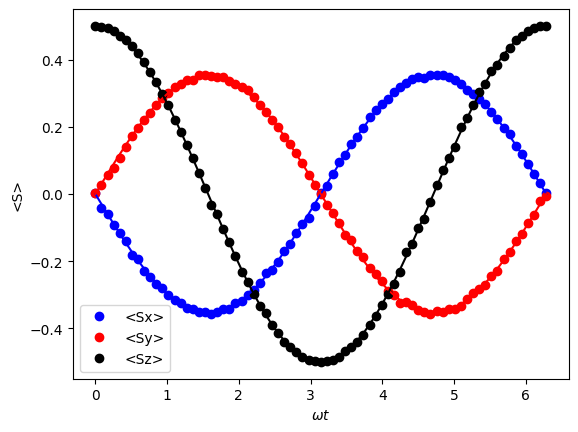

In [22]:
tau_range = np.linspace(0, 2*np.pi, Nt)

sampler = StatevectorSampler()

nshots = 8192

pub = (timecirc, tau_range)

job = sampler.run([pub], shots=nshots)
result = job.result()[0]

Sx = np.zeros(Nt)
Sy = np.zeros(Nt)
Sz = np.zeros(Nt)

for n in range(0,Nt):
    simcounts = result.data.c.get_counts(n)
    states = list(simcounts.keys())
    for j in range(0,len(states)):
        state = states[j]
        if (state[0]=='0'):
            Sx[n] = Sx[n] + 0.5*simcounts[state]/nshots
        else:
            Sx[n] = Sx[n] - 0.5*simcounts[state]/nshots

        if (state[1]=='0'):
            Sy[n] = Sy[n] + 0.5*simcounts[state]/nshots
        else:
            Sy[n] = Sy[n] - 0.5*simcounts[state]/nshots

        if (state[2]=='0'):
            Sz[n] = Sz[n] + 0.5*simcounts[state]/nshots
        else:
            Sz[n] = Sz[n] - 0.5*simcounts[state]/nshots


plt.plot(tau_range,Sx,'bo',label='<Sx>')
plt.plot(tau_range,Sy,'ro',label='<Sy>')
plt.plot(tau_range,Sz,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

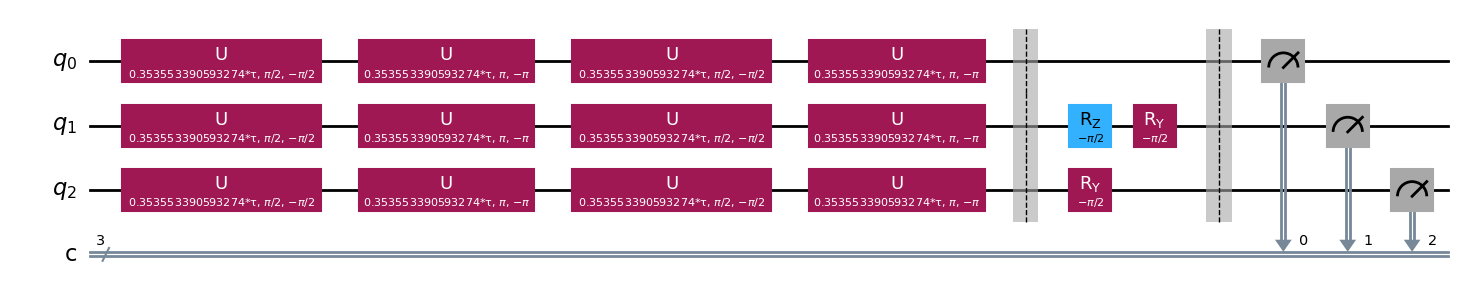

In [23]:
tau = Parameter('τ')
Nt = 75

tau_range = np.linspace(0, 2*np.pi, Nt)

qr = QuantumRegister(3,'q')
cr = ClassicalRegister(3,'c')

timecirc0 = QuantumCircuit(qr,cr)

#vary this:
ntrot = 2

for i in range(0,ntrot):
    timecirc0.u(tau/(np.sqrt(2)*ntrot),np.pi/2,-np.pi/2,qr)
    timecirc0.u(tau/(np.sqrt(2)*ntrot),np.pi,-np.pi,qr)

timecirc0.barrier(qr)
timecirc0.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc0.rz(-np.pi/2,1)
timecirc0.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc0.barrier(qr)
#no rotation needed to measure <Sz>

timecirc0.measure(qr,cr)
timecirc0.draw('mpl')

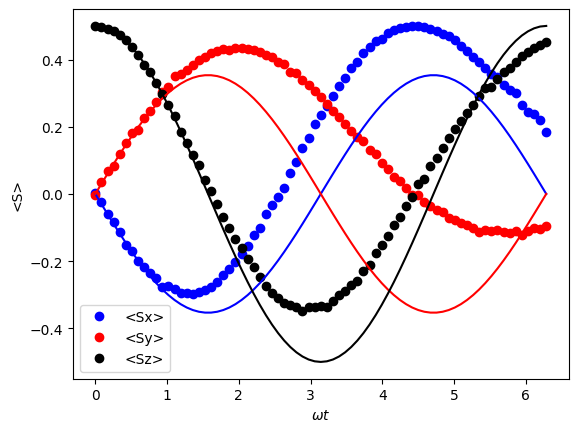

In [24]:
sampler = StatevectorSampler()

nshots = 8192

pub = (timecirc0, tau_range)

job = sampler.run([pub], shots=nshots)
result = job.result()[0]

Sx = np.zeros(Nt)
Sy = np.zeros(Nt)
Sz = np.zeros(Nt)

for n in range(0,Nt):
    simcounts = result.data.c.get_counts(n)
    states = list(simcounts.keys())
    for j in range(0,len(states)):
        state = states[j]
        if (state[0]=='0'):
            Sx[n] = Sx[n] + 0.5*simcounts[state]/nshots
        else:
            Sx[n] = Sx[n] - 0.5*simcounts[state]/nshots

        if (state[1]=='0'):
            Sy[n] = Sy[n] + 0.5*simcounts[state]/nshots
        else:
            Sy[n] = Sy[n] - 0.5*simcounts[state]/nshots

        if (state[2]=='0'):
            Sz[n] = Sz[n] + 0.5*simcounts[state]/nshots
        else:
            Sz[n] = Sz[n] - 0.5*simcounts[state]/nshots

plt.plot(tau_range,Sx,'bo',label='<Sx>')
plt.plot(tau_range,Sy,'ro',label='<Sy>')
plt.plot(tau_range,Sz,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()